In [287]:
from pathlib import Path
import numpy as np
from halo import read_halocat, read_halomemcat, read_haloqcat, Halos

WD = Path.cwd() / "Run_multi" / "Run1"
step_numbers = np.array([19, 28, 37, 46, 55, 64, 73, 82, 91, 100, 109, 118, 127, 136, 145, 154, 163, 172, 182, 189])

halos_list = []
for i in range(len(step_numbers)):
    step_number = step_numbers[i]
    halocatpath = WD / f"FoF_halo_cat.{step_number:05d}"
    haloqcatpath = WD / f"FoFHaloQuantities{step_number:05d}.bin"
    halomemcatpath = WD / f"FoF_member_particle.{step_number:05d}"

    halocat, snapshot_props = read_halocat(halocatpath)
    haloqcat = read_haloqcat(haloqcatpath)
    halomemcat = read_halomemcat(halomemcatpath)
    
    initial = False if i > 0 else True
    
    halos = Halos(halocat, haloqcat, halomemcat, snapshot_props, initial=initial)
    halos_list.append(halos)

In [288]:
from tqdm import trange
for i in trange(1, len(halos_list)):
    _ = halos_list[i].match_halos_previous_timestep(halos_list[i-1])

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:38<00:00,  2.02s/it]


In [165]:
hidnow = halos_list[-1].hid_matched_now
hidprev = halos_list[-1].hid_matched_prev
massnow = halos_list[-1].mass[hidnow]
massprev = halos_list[-2].mass[hidprev]

uhidnow = np.unique(hidnow)
umsort = np.argsort(halos_list[-1].mass[uhidnow])
hid_massive = uhidnow[umsort][-3:]
hid_massive

array([343997, 302689, 137961])

In [166]:
pick_massive_hid = np.isin(hidnow, hid_massive)

hidnow_massive = hidnow[pick_massive_hid]
hidprev_massive = hidprev[pick_massive_hid]
massnow_massive = massnow[pick_massive_hid]
massprev_massive = massprev[pick_massive_hid]
print(hidnow_massive, hidprev_massive, massnow_massive, massprev_massive, sep="\n")

[343997 343997 343997 343997 343997 343997 137961 137961 137961 137961
 137961 137961 137961 137961 137961 302689 302689 302689 302689 302689]
[343278 343703 342108 343121 342277 342711  50648  50229 137237 137161
 137171 137182 137234 138679  50734 303255 301083 301570 302059 301893]
[2.3577250e+15 2.3577250e+15 2.3577250e+15 2.3577250e+15 2.3577250e+15
 2.3577250e+15 2.8118507e+15 2.8118507e+15 2.8118507e+15 2.8118507e+15
 2.8118507e+15 2.8118507e+15 2.8118507e+15 2.8118507e+15 2.8118507e+15
 2.4376055e+15 2.4376055e+15 2.4376055e+15 2.4376055e+15 2.4376055e+15]
[2.7061120e+12 4.1092813e+12 2.3130240e+15 3.5079229e+12 8.3187886e+12
 2.0045273e+12 5.0113182e+12 2.5056591e+12 2.3052065e+12 2.6268329e+15
 2.0045273e+12 3.8787606e+13 2.2049802e+12 5.4422919e+13 2.8063383e+12
 2.1047538e+12 2.5779223e+15 1.8301335e+14 2.3052065e+12 9.0203729e+12]


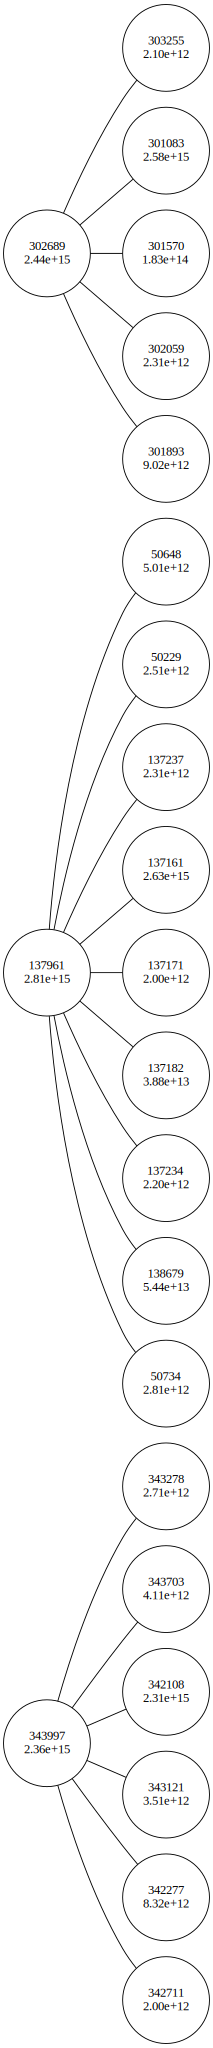

In [167]:
from graphviz import Graph

node_kwargs = {'style': 'filled',
            #    'label': '',
               'fillcolor': 'white', 'shape': 'circle', 'fixedsized': 'true',
                   }

graph = Graph("now")
graph.attr(rankdir="LR")
subgraph = Graph("prev")
subgraph.attr(rank="same")
for i in range(len(hidnow_massive)):
    graph.node(str(hidnow_massive[i]), f"{hidnow_massive[i]}\n{massnow_massive[i]:.2e}", **node_kwargs)
    graph.node(str(hidprev_massive[i]), f"{hidprev_massive[i]}\n{massprev_massive[i]:.2e}", **node_kwargs)
for i in range(len(hidnow_massive)):
    graph.edge(str(hidnow_massive[i]), str(hidprev_massive[i]))

graph.subgraph(subgraph)
graph

In [281]:
from graphviz import Graph, Digraph

hidnow = halos_list[-1].hid_matched_now
hidprev = halos_list[-1].hid_matched_prev
massnow = halos_list[-1].mass[hidnow]
massprev = halos_list[-2].mass[hidprev]

hidnow_orig = hidnow
hidprev_orig = hidprev
massnow_orig = massnow
massprev_orig = massprev

uhidnow = np.unique(hidnow)
umsort = np.argsort(halos_list[-1].mass[uhidnow])
hid_massive = uhidnow[umsort][-3:]

node_kwargs = {'style': 'filled',
               'label': '',
               'fillcolor': 'black', 'shape': 'circle', 'fixedsized': 'true',
                   'width': '0.01'}

edge_kwargs = {'dir': 'none', 'penwidth': '5'}

# node_kwargs = {}

# sizef = lambda x: np.log10(x)/15
sizef = lambda x: (x/1e15)**(1/3)
list_rankstrings = []
for k in range(len(hid_massive)):
    rankstrings = []
    graph = Graph("now")
    graph.attr(rankdir="LR", splines="false", sep="0", ranksep="5")
    pick_massive_hid = np.isin(hidnow_orig, hid_massive[k])

    hidnow_massive = hidnow_orig[pick_massive_hid]
    hidprev_massive = hidprev_orig[pick_massive_hid]
    massnow_massive = massnow_orig[pick_massive_hid]
    massprev_massive = massprev_orig[pick_massive_hid]
    # for i in range(len(np.unique(hidnow_massive))):
    
    
    with graph.subgraph(name=f"cluster_{k}") as subg:
        subg.attr(rank='same', sep="0", ranksep="0")
        
        # node_kwargs['width'] = f"{sizef(massnow_massive[0]):.2f}"
        # node_kwargs_color_original = node_kwargs['fillcolor']
        # node_kwargs['fillcolor'] = 'red'
        # subg.node(f"{19}_{hidnow_massive[0]}", **node_kwargs)
        # node_kwargs['fillcolor'] = node_kwargs_color_original
        
        msort = np.argsort(massprev_massive)[::-1]
        for i in range(len(hidnow_massive)):
            node_kwargs['width'] = f"{sizef(massprev_massive[msort][i]):.2f}"
            subg.node(f"{18}_{hidprev_massive[msort][i]}", **node_kwargs)
            
        rnkstr = "{rank=same" + "; ".join([f'"{18}_{_hid}"' for _hid in hidprev_massive]) + "; }"
        rankstrings.append(rnkstr)
            
            
        # for i in range(len(hidnow_massive)):
        #     subg.edge(f"{19}_{hidnow_massive[msort][i]}", f"{18}_{hidprev_massive[msort][i]}", **edge_kwargs)

        hidprev_track = hidprev_massive
        for i in range(len(halos_list)-2, 5, -1):
            hidnow_all = halos_list[i].hid_matched_now
            hidprev_all = halos_list[i].hid_matched_prev
            
            trackmask = np.isin(hidnow_all, hidprev_track)
            hidnow = hidnow_all[trackmask]
            hidprev = hidprev_all[trackmask]
            
            massnow = halos_list[i].mass[hidnow]
            massprev = halos_list[i-1].mass[hidprev]
            
            msort = np.argsort(massprev)[::-1]
            for j in range(len(hidprev)):
                node_kwargs['width'] = f"{sizef(massprev[msort][j]):.2f}"
                subg.node(f"{i-1}_{hidprev[msort][j]}", **node_kwargs)
                
            for j in range(len(hidprev)):
                subg.edge(f"{i-1}_{hidprev[msort][j]}", f"{i}_{hidnow[msort][j]}", **edge_kwargs)
            
            rnkstr = "{rank=same" +"; ".join([f'"{i-1}_{_hid}"' for _hid in hidprev]) + "; }"
            rankstrings.append(rnkstr)
        
            hidprev_track = hidprev
    list_rankstrings.append(rankstrings)
    # subg_track = subg
    graph.render(f"massive_{k}", format="png", cleanup=True)
    with open(f"massive_{k}.dot", "w") as f:
        f.write(graph.source)

In [279]:
for rankstrings in list_rankstrings:
    print("\n".join(rankstrings))

{rank=same"18_343278"; "18_343703"; "18_342108"; "18_343121"; "18_342277"; "18_342711"; }
{rank=same"17_339439"; "17_340804"; "17_340801"; "17_339695"; "17_339696"; "17_339441"; "17_340009"; "17_339915"; "17_339701"; }
{rank=same"16_337427"; "16_337751"; "16_336340"; "16_336581"; "16_336360"; "16_337424"; "16_337657"; "16_337193"; "16_336574"; "16_336865"; "16_336577"; "16_336344"; }
{rank=same"15_288653"; "15_289722"; "15_289632"; "15_289089"; "15_288414"; "15_288854"; "15_288943"; "15_288432"; "15_288643"; "15_289003"; "15_288647"; "15_288418"; "15_288434"; }
{rank=same"14_328648"; "14_329148"; "14_328813"; "14_327505"; "14_328400"; "14_328730"; "14_328033"; "14_328176"; "14_328026"; "14_328025"; "14_327938"; "14_327936"; "14_327725"; "14_327509"; "14_327507"; "14_327526"; }
{rank=same"13_301675"; "13_302153"; "13_301599"; "13_302154"; "13_301823"; "13_301750"; "13_301196"; "13_300538"; "13_301671"; "13_301368"; "13_301133"; "13_300762"; "13_301050"; "13_300966"; "13_300766"; "13_300

In [270]:
print(graph.source)

graph now {
	rankdir=LR ranksep=5 sep=0 splines=false
	"19_137961" [label="" fillcolor=black fixedsized=true shape=circle style=filled width=1.41]
	subgraph cluster_2 {
		rank=same ranksep=0 sep=0
		"18_137161" [label="" fillcolor=black fixedsized=true shape=circle style=filled width=1.38]
		"18_138679" [label="" fillcolor=black fixedsized=true shape=circle style=filled width=0.38]
		"18_137182" [label="" fillcolor=black fixedsized=true shape=circle style=filled width=0.34]
		"18_50648" [label="" fillcolor=black fixedsized=true shape=circle style=filled width=0.17]
		"18_50734" [label="" fillcolor=black fixedsized=true shape=circle style=filled width=0.14]
		"18_50229" [label="" fillcolor=black fixedsized=true shape=circle style=filled width=0.14]
		"18_137237" [label="" fillcolor=black fixedsized=true shape=circle style=filled width=0.13]
		"18_137234" [label="" fillcolor=black fixedsized=true shape=circle style=filled width=0.13]
		"18_137171" [label="" fillcolor=black fixedsized=tru

In [232]:
from graphviz import Graph, Digraph
from matplotlib import pyplot as plt

hidnow = halos_list[-1].hid_matched_now
hidprev = halos_list[-1].hid_matched_prev
massnow = halos_list[-1].mass[hidnow]
massprev = halos_list[-2].mass[hidprev]

hidnow_orig = hidnow
hidprev_orig = hidprev
massnow_orig = massnow
massprev_orig = massprev

uhidnow = np.unique(hidnow)
umsort = np.argsort(halos_list[-1].mass[uhidnow])
hid_massive = uhidnow[umsort][-3:]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

sizef = lambda x: np.log10(x)/150
sizef = lambda x: (x/1e14)**(1/3.2)

nodekwargs = {"c":"k", "s":3, "zorder":10,}
edgekwargs = {"c":"k", "lw":0.5, "zorder":5,}

ystep = 0.1
yleap = 30

for k in range(len(hid_massive)):
    pick_massive_hid = np.isin(hidnow_orig, hid_massive[k])

    hidnow_massive = hidnow_orig[pick_massive_hid]
    hidprev_massive = hidprev_orig[pick_massive_hid]
    massnow_massive = massnow_orig[pick_massive_hid]
    massprev_massive = massprev_orig[pick_massive_hid]
    
    nodekwargs['s'] = sizef(massnow_massive[0])
    ax.scatter(19, yleap*k, **nodekwargs)
        
    with graph.subgraph(name=f"cluster_{k}") as subg:
        subg.attr(rank='same')
            
        msort = np.argsort(massprev_massive)[::-1]
        for i in range(len(hidnow_massive)):
            nodekwargs['s'] = f"{sizef(massprev_massive[msort][i]):.2f}"
            ax.scatter(18, yleap*k+ystep*i, **nodekwargs)
            ax.plot([18, 19], [yleap*k+ystep*i, yleap*k], **edgekwargs)
            
        hidprev_track = hidprev_massive
        for i in range(len(halos_list)-2, 10, -1):
            print(i)
            hidnow_all = halos_list[i].hid_matched_now
            hidprev_all = halos_list[i].hid_matched_prev
            
            trackmask = np.isin(hidnow_all, hidprev_track)
            hidnow = hidnow_all[trackmask]
            hidprev = hidprev_all[trackmask]
            
            massnow = halos_list[i].mass[hidnow]
            massprev = halos_list[i-1].mass[hidprev]
            
            for j in range(len(hidprev)):
                node_kwargs['width'] = f"{sizef(massprev[j]):.2f}"
                subg.node(f"{i-1}_{hidprev[j]}", **node_kwargs)
                nodekwargs['s'] = f"{sizef(massprev[j]):.2f}"
                ax.scatter(i-1, yleap*k+ystep*j, **nodekwargs)
            for j in range(len(hidprev)):
                subg.edge(f"{i-1}_{hidprev[j]}", f"{i}_{hidnow[j]}", dir="none")
    
        
            hidprev_track = hidprev
    # subg_track = subg
    
graph

<bound method Dot.node of <graphviz.graphs.Graph object at 0x14d21543ea10>>

In [233]:
print(graph.source)

'graph now {\n\tsplines=false\n\t"19_343997" [label="" fillcolor=white shape=circle style=filled width=0.01]\n\tsubgraph cluster_0 {\n\t\trank=same\n\t\t"18_343278" [label="" fillcolor=white shape=circle style=filled width=0.01]\n\t\t"18_343703" [label="" fillcolor=white shape=circle style=filled width=0.01]\n\t\t"18_342108" [label="" fillcolor=white shape=circle style=filled width=0.01]\n\t\t"18_343121" [label="" fillcolor=white shape=circle style=filled width=0.01]\n\t\t"18_342277" [label="" fillcolor=white shape=circle style=filled width=0.01]\n\t\t"18_342711" [label="" fillcolor=white shape=circle style=filled width=0.01]\n\t\t"19_343997" -- "18_343278" [dir=none]\n\t\t"19_343997" -- "18_343703" [dir=none]\n\t\t"19_343997" -- "18_342108" [dir=none]\n\t\t"19_343997" -- "18_343121" [dir=none]\n\t\t"19_343997" -- "18_342277" [dir=none]\n\t\t"19_343997" -- "18_342711" [dir=none]\n\t\t"17_339439" [label="" fillcolor=white shape=circle style=filled width=0.01]\n\t\t"17_340804" [label="" 

In [134]:
len(hidprev_all)

333835

In [107]:
for i in range(5, 0, -1):
    print(i)

5
4
3
2
1


In [74]:
import pydot
import networkx

graph = pydot.Dot("my_graph", graph_type="graph", bgcolor="k", rankdir="LR")
graph.set_rank("rank = same; a; b; c;")
# Add nodes
my_node = pydot.Node("a", label="Foo", shape="circle", color="white", style="filled", rank="same")
graph.add_node(my_node)
# Or, without using an intermediate variable:
my_node2 = pydot.Node("b", shape="circle", color="white", style="filled")
graph.add_node(my_node2)
my_node3 = pydot.Node("c", shape="circle", color="white", style="filled")
graph.add_node(my_node3)

graph.get_rank()
# Add edges
my_edge = pydot.Edge("a", "b", color="white",)
graph.add_edge(my_edge)
# Or, without using an intermediate variable:
graph.add_edge(pydot.Edge("b", "c", color="white"))
graph.write_png("test.png")

In [85]:
a = graph.get_node("a")
a[0].get_width()